In [1]:
# efficientnet_covidnet.py

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class COVIDNetClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(COVIDNetClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [4]:
def load_data(split, data_dir):
    features = np.load(os.path.join(data_dir, f"{split}_features.npy"))
    labels = np.load(os.path.join(data_dir, f"{split}_labels.npy"))
    return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

In [5]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title="EfficientNet"):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            test_loss += loss.item()  # Accumulate the test loss
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(yb.cpu().numpy())
    
    average_test_loss = test_loss / len(test_loader)
    accuracy = correct / total
    return y_pred, y_true, average_test_loss, accuracy

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25):
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
                correct += (outputs.argmax(1) == yb).sum().item()
                total += yb.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        if val_accuracies[-1] > best_acc:
            best_acc = val_accuracies[-1]
            torch.save(model.state_dict(), "efficientnet_covidnet.pt")
            print(f"✅ Best model saved at epoch {epoch+1}")

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

✅ Best model saved at epoch 1
Epoch 1/25 - Train Loss: 0.5027, Train Acc: 0.8069, Val Loss: 0.3285, Val Acc: 0.8811
✅ Best model saved at epoch 2
Epoch 2/25 - Train Loss: 0.3588, Train Acc: 0.8648, Val Loss: 0.2835, Val Acc: 0.8953
✅ Best model saved at epoch 3
Epoch 3/25 - Train Loss: 0.3126, Train Acc: 0.8814, Val Loss: 0.2672, Val Acc: 0.8987
✅ Best model saved at epoch 4
Epoch 4/25 - Train Loss: 0.2807, Train Acc: 0.8938, Val Loss: 0.2419, Val Acc: 0.9077
✅ Best model saved at epoch 5
Epoch 5/25 - Train Loss: 0.2525, Train Acc: 0.9058, Val Loss: 0.2418, Val Acc: 0.9086
Epoch 6/25 - Train Loss: 0.2385, Train Acc: 0.9089, Val Loss: 0.2385, Val Acc: 0.9064
Epoch 7/25 - Train Loss: 0.2156, Train Acc: 0.9184, Val Loss: 0.2513, Val Acc: 0.8996
Epoch 8/25 - Train Loss: 0.2013, Train Acc: 0.9252, Val Loss: 0.2399, Val Acc: 0.9055
✅ Best model saved at epoch 9
Epoch 9/25 - Train Loss: 0.1907, Train Acc: 0.9287, Val Loss: 0.2302, Val Acc: 0.9155
Epoch 10/25 - Train Loss: 0.1707, Train Acc: 0

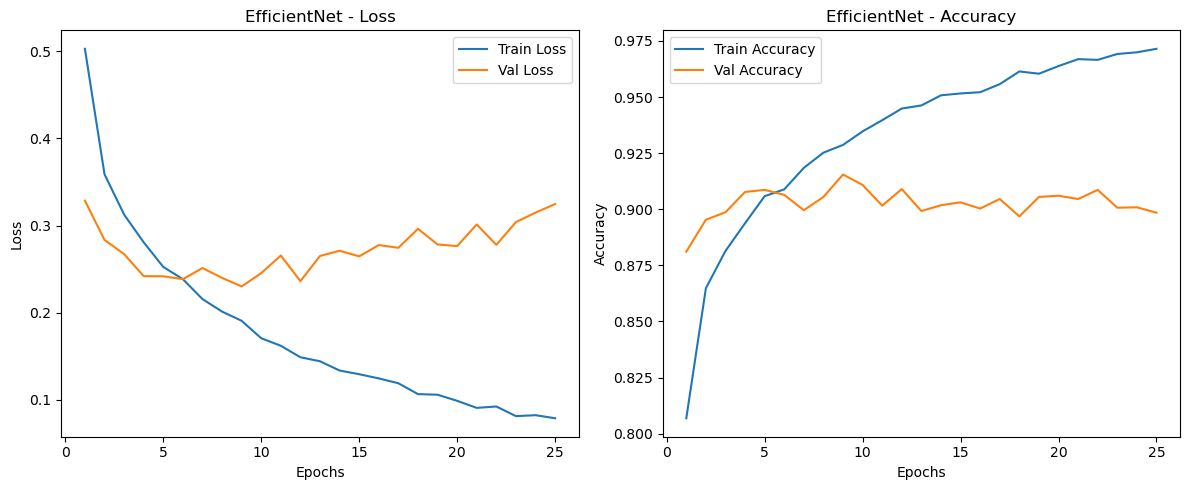

C:\Users\Safi\AppData\Local\Temp\ipykernel_27928\2400717677.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("efficientnet_covidnet.pt")

Test Loss: 0.2095
Test Accuracy: 0.9240


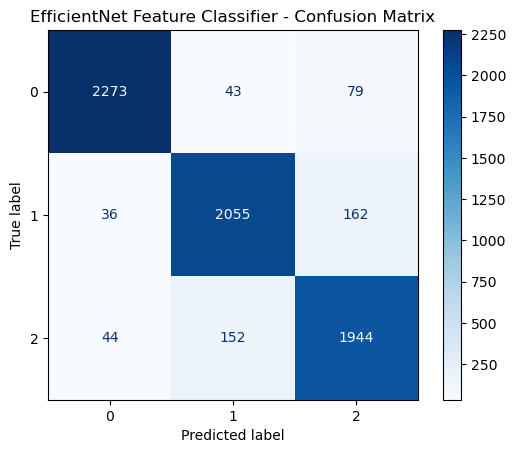

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      2395
           1       0.91      0.91      0.91      2253
           2       0.89      0.91      0.90      2140

    accuracy                           0.92      6788
   macro avg       0.92      0.92      0.92      6788
weighted avg       0.92      0.92      0.92      6788



In [8]:
if __name__ == "__main__":
    num_classes = 3
    batch_size = 32

    X_train, y_train = load_data("train", "efficientnet_dataset/train")
    X_val, y_val = load_data("val", "efficientnet_dataset/val")
    X_test, y_test = load_data("test", "efficientnet_dataset/test")

    input_dim = X_train.shape[1]
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

    model = COVIDNetClassifier(input_dim=input_dim, num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs=25
    )

    plot_metrics(train_losses, val_losses, train_accs, val_accs, title="EfficientNet")

    model.load_state_dict(torch.load("efficientnet_covidnet.pt"))
    y_pred, y_true, test_loss, accuracy = evaluate(model, test_loader, criterion)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("EfficientNet Feature Classifier - Confusion Matrix")
    plt.show()

    print("Classification Report:\n", classification_report(y_true, y_pred))